<a href="https://colab.research.google.com/github/AlexandreLarget/tensorflow_certification_training/blob/main/10_time_series_forecasting_with_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting fundamentals with Tensorflow + Milestone Project 3: BitPredict

In [ ]:
!nvidia-smi

Wed Nov  9 07:18:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get data

In [ ]:
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-11-09 07:18:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2022-11-09 07:18:49 (6.13 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series with pandas

In [ ]:
import pandas as pd
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])

In [ ]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [ ]:
len(df)

2787

In [ ]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "price"})

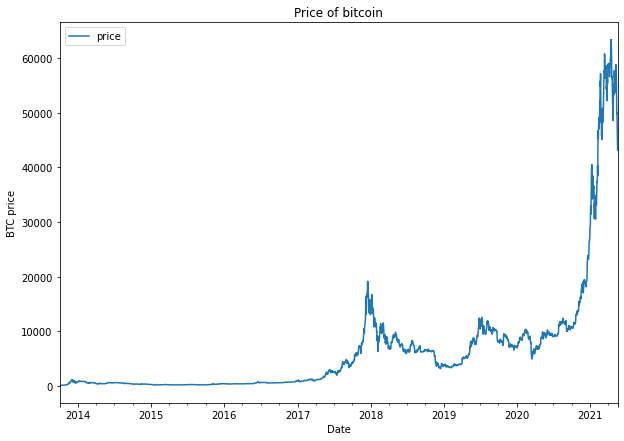

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC price")
plt.title("Price of bitcoin");

## Importing time series data with Python's CSV module


In [ ]:
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip the header
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
    btc_price.append(float(line[2]))

In [ ]:
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

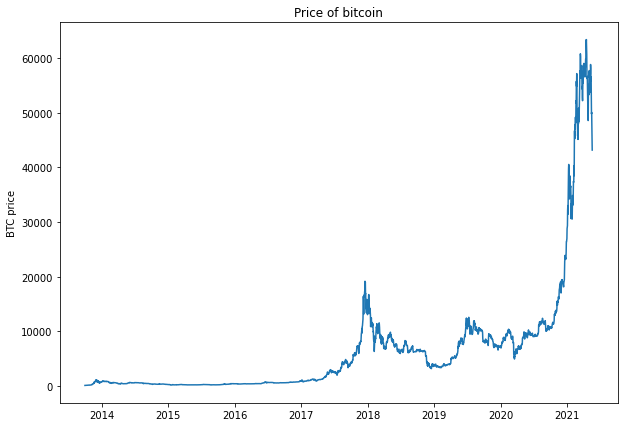

In [ ]:
import numpy as np
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC price")
plt.title("Price of bitcoin");

## Format data part 1

### Creating train and test sets with time series data (the wrong way)

In [ ]:
bitcoin_prices[:5]

,price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Get bitcoin dat array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

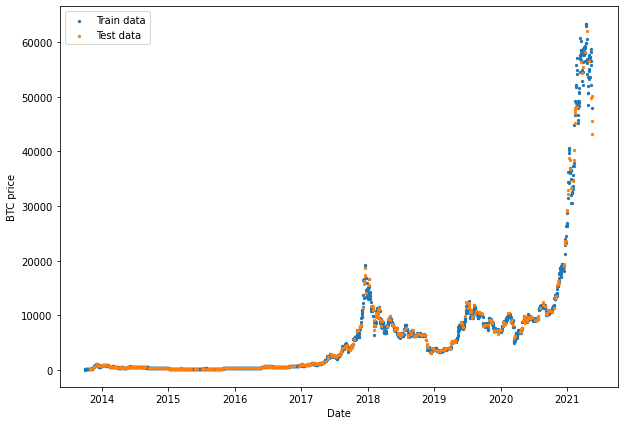

In [ ]:
# Let's plot our wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC price")
plt.legend();

### Create train and test sets for time series (the right way)

In [ ]:
split_size = int(0.8*len(prices)) # 80% train

# Create train data splits
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

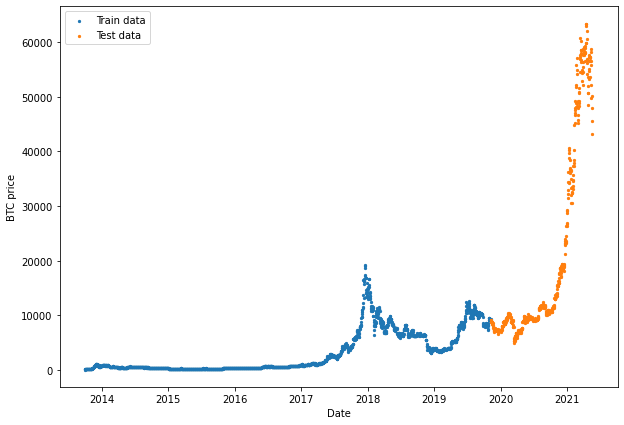

In [ ]:
# Let's plot our wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC price")
plt.legend();

## Create a plotting function

In [ ]:
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a serie of points in time) against values

  Parameters:
  -----------
  timesteps: array of timestep values.
  values: array of values across time.
  format: style of the plot, default is scatter.
  start: where to start, default is 0.
  end: where to end the plot.
  label: label to show on plot about values.
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC price")
  if label: 
    plt.legend(fontsize=14)
    plt.grid(True)

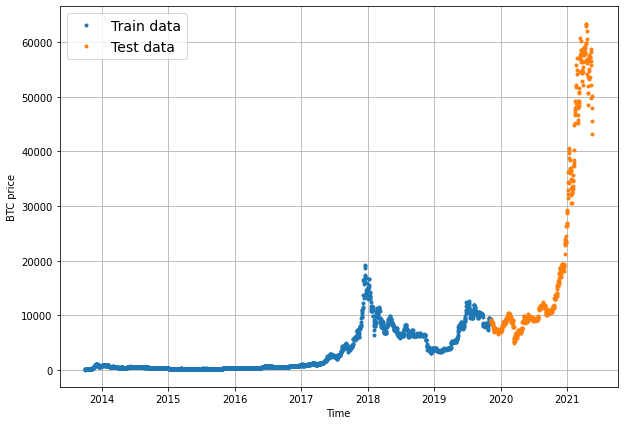

In [ ]:
plt.figure(figsize=(10,7))
plot_time_series(X_train, y_train, label="Train data")
plot_time_series(X_test, y_test, label="Test data")

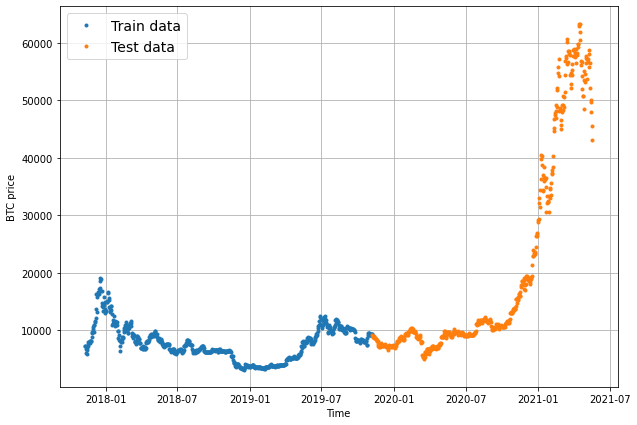

In [ ]:
plt.figure(figsize=(10,7))
plot_time_series(X_train, y_train, start=1500, label="Train data")
plot_time_series(X_test, y_test, label="Test data")

## Modelling experiments 

## Model 0: Naive forecast (baseline)

In [ ]:
# Create a naive forecast
naive_forecast = y_test[:-1]

y_test[:10], naive_forecast[:10]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]))

In [ ]:
y_test[-10:], naive_forecast[-10:]

(array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
        52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
        45604.61575361, 43144.47129086]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [ ]:
len(y_test), len(naive_forecast)

(558, 557)

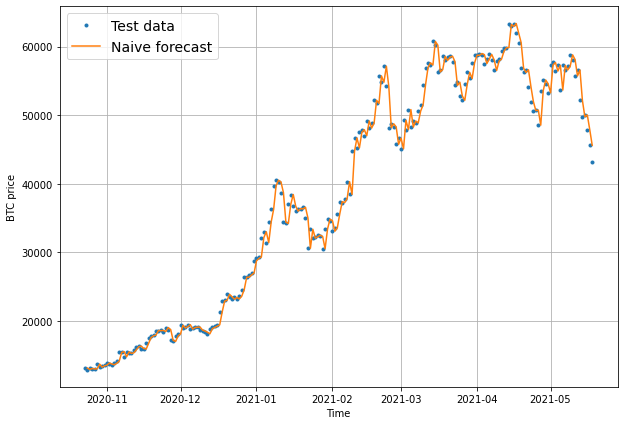

In [ ]:
# Plot the naive forecast
plt.figure(figsize=(10,7))
#plot_time_series(X_train, y_train, start=1500, label="Train data")
plot_time_series(X_test, y_test, start=350, label="Test data")
plot_time_series(X_test[1:], naive_forecast,start=350, format="-", label="Naive forecast")

## Implementing metrics

In [ ]:
import tensorflow as tf

In [ ]:
# MASE (mean absolut scaled error) implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae / mae_naive_no_season

In [ ]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [ ]:
# Create a function returning our evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (numpy default is float 64 which can lead to datatype errors)
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
naive_results = evaluate_preds(y_test[1:], naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [ ]:
tf.reduce_mean(y_test), tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737222>,
 <tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>,
 <tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>)

## Format data Part 2: Windowing our dataset

Why do we window ?

We window our time series dataset to turn our data into a supervised learning problem.

In [ ]:
print(f"We want to use: {btc_price[:7]}\n to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795]
 to predict this: 123.033


In [ ]:
# Let's setup global variables for window and horizon size
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
def get_labelled_window(x, horizon=HORIZON):
  """
  Create labels for windowed dataset.
  E.g.if horizon = 1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Ouput: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon]

In [ ]:
test_window, test_label = get_labelled_window(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


In [ ]:
# Create function to view NumPy arraysas windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # Create a window of a specific size
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)
  # Create a 2D array of multiple window steps
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon -1)), axis=0).T
  # Index on the target array with 2D multiple window steps
  windowed_array = x[window_indexes]
  # Get the labelled windows
  windows, labels = get_labelled_window(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
len(prices)

2787

In [ ]:
window_steps = np.expand_dims(np.arange(7+1), axis=0)
window_steps

array([[0, 1, 2, 3, 4, 5, 6, 7]])

In [ ]:
np.expand_dims(np.arange(len(prices) - (7 +1 -1)), axis=0).T

array([[   0],
       [   1],
       [   2],
       ...,
       [2777],
       [2778],
       [2779]])

In [ ]:
window_indexes = window_steps + np.expand_dims(np.arange(len(prices) - (7 +1 -1)), axis=0).T
window_indexes

array([[   0,    1,    2, ...,    5,    6,    7],
       [   1,    2,    3, ...,    6,    7,    8],
       [   2,    3,    4, ...,    7,    8,    9],
       ...,
       [2777, 2778, 2779, ..., 2782, 2783, 2784],
       [2778, 2779, 2780, ..., 2783, 2784, 2785],
       [2779, 2780, 2781, ..., 2784, 2785, 2786]])

In [ ]:
prices[window_indexes]

array([[  123.65499   ,   125.455     ,   108.58483   , ...,
          120.65533   ,   121.795     ,   123.033     ],
       [  125.455     ,   108.58483   ,   118.67466   , ...,
          121.795     ,   123.033     ,   124.049     ],
       [  108.58483   ,   118.67466   ,   121.33866   , ...,
          123.033     ,   124.049     ,   125.96116   ],
       ...,
       [58788.20967893, 58102.19142623, 55715.54665129, ...,
        49764.1320816 , 50032.69313676, 47885.62525472],
       [58102.19142623, 55715.54665129, 56573.5554719 , ...,
        50032.69313676, 47885.62525472, 45604.61575361],
       [55715.54665129, 56573.5554719 , 52147.82118698, ...,
        47885.62525472, 45604.61575361, 43144.47129086]])

In [ ]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# View the first 3
for i in range(3):
  print(f"Windows: {full_windows[i]} -> Label: {full_labels[i]}")

Windows: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: 123.033
Windows: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: 124.049
Windows: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: 125.96116


In [ ]:
# View the last 3
for i in range(3):
  print(f"Windows: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Windows: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: 47885.6252547166
Windows: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: 45604.6157536131
Windows: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: 43144.4712908603


## Formating our window dataset with tf.keras.preprocessing.timeseries_dataset_from_array

In [ ]:
input_data = prices
targets = prices[7:]
dataset = tf.keras.preprocessing.timeseries_dataset_from_array(data=input_data,
                                                     targets=targets,
                                                     sequence_length=7,
                                                     sequence_stride=1)

In [ ]:
input_data_min = prices[:10]
targets = prices[7:]
dataset_min = tf.keras.preprocessing.timeseries_dataset_from_array(data=input_data_min,
                                                     targets=targets,
                                                     sequence_length=7,
                                                     sequence_stride=1)

In [ ]:
for window, label in dataset_min:
  print(f"Window: {window}, -> Label: {label}")

Window: [[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]
 [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ]
 [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ]
 [118.67466 121.33866 120.65533 121.795   123.033   124.049   125.96116]], -> Label: [123.033   124.049   125.96116 125.27966]


Need to split into train / test before turning into tensorflow dataset.

## Turning windows into turning and test sets

In [ ]:
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split))
  train_window = windows[:split_size]
  train_label = labels[:split_size]
  test_window = windows[split_size:]
  test_label = labels[split_size:]

  return train_window, test_window, train_label, test_label

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

## Make a modeling checkpoint

In [ ]:
import os

# Create a function to implement a model checkpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiement"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

## Model 1: Dense model (window=7, horizon=1)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Set ranodm sedd
tf.random.set_seed(42)

# Model 1 !
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1")

# Compile
model_1.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# Fit the model
model_1_history = model_1.fit(x=train_windows,
                              y=train_labels,
                              epochs=100,
                              verbose=1,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 3s 41ms/step - loss: 780.3455 - mae: 780.3455 - mse: 2312725.7500 - val_loss: 2279.6528 - val_mae: 2279.6528 - val_mse: 12772731.0000
Epoch 2/100
18/18 [==============================] - 1s 35ms/step - loss: 247.6756 - mae: 247.6756 - mse: 285481.1875 - val_loss: 1005.9993 - val_mae: 1005.9993 - val_mse: 3441833.2500
Epoch 3/100
18/18 [==============================] - 0s 25ms/step - loss: 188.4116 - mae: 188.4116 - mse: 171891.6094 - val_loss: 923.2862 - val_mae: 923.2861 - val_mse: 2868220.7500
Epoch 4/100
18/18 [==============================] - 0s 27ms/step - loss: 169.4340 - mae: 169.4340 - mse: 151700.5781 - val_loss: 900.5872 - val_mae: 900.5872 - val_mse: 2683715.5000
Epoch 5/100
18/18 [==============================] - 1s 30ms/step - loss: 165.0894 - mae: 165.0894 - mse: 145490.7812 - val_loss: 895.2237 - val_mae: 895.2237 - val_mse: 2564574.5000
Epoch 6/100
18/18 [==============================] - 1s 34ms/step - loss: 158.5

In [ ]:
# Evaluate the model
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 585.9758 - mae: 585.9758 - mse: 1197802.1250


[585.9757690429688, 585.9757690429688, 1197802.125]

In [ ]:
# Load in saved best performing model_1 and evaluate
model_1 = tf.keras.models.load_model("/content/model_experiement/model_1")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.9510 - mae: 568.9510 - mse: 1171743.6250


[568.9510498046875, 568.9510498046875, 1171743.625]

## Making forecast with a model

In [ ]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [ ]:
model_1_preds = make_preds(model_1, test_windows)

18/18 [==============================] - 0s 1ms/step


In [ ]:
model_1_results = evaluate_preds(y_true=test_labels,
                                 y_pred=model_1_preds)
model_1_results

{'mae': 568.95105,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.9994894}

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

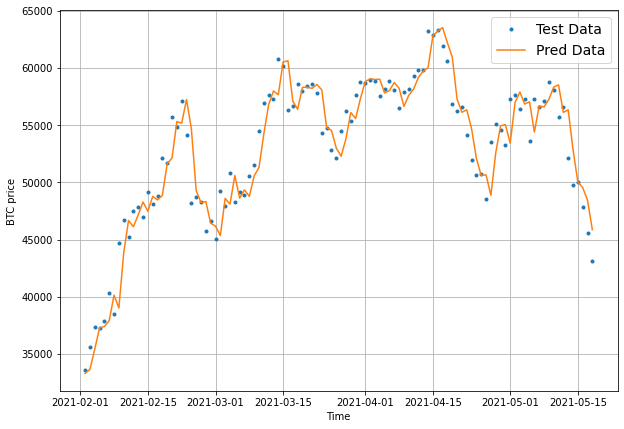

In [ ]:
#Let's plot our model 1 predictions
offset = 450
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels, start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds, start=offset, label="Pred Data", format="-")

## Model 2: Dense model (window=30, horizon=1)

In [ ]:
WINDOW_SIZE = 30
HORIZON = 1

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE)
len(full_windows), len(full_labels)

(2757, 2757)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [ ]:
tf.random.set_seed(42)

# Create model 2
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_2")

# Compile the model
model_2.compile(loss="mae",
                optimizer="Adam",
                metrics=["mae", "mse"])

# Fit the model
model_2_history = model_2.fit(x=train_windows,
                              y=train_labels,
                              epochs=100,
                              verbose=0,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint("model_2")])

In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               3968      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2 = tf.keras.models.load_model("/content/model_experiement/model_2")

In [ ]:
model_2_preds = make_preds(model=model_2, input_data=test_windows)

18/18 [==============================] - 0s 1ms/step


In [ ]:
model_2_results = evaluate_preds(y_true=test_labels,
                                 y_pred=model_2_preds)
model_2_results

{'mae': 605.8741,
 'mse': 1273360.8,
 'rmse': 1128.4329,
 'mape': 2.726445,
 'mase': 1.0590738}

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

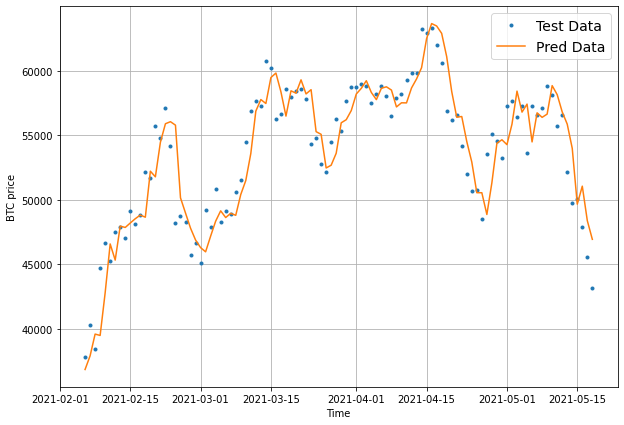

In [ ]:
#Let's plot our model 2 predictions
offset = 450
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels, start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_2_preds, start=offset, label="Pred Data", format="-")

## Model 3: Dense model (window=30, horizon=7)

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [ ]:
tf.random.set_seed(42)

# Create the model
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_3")

# Compile the model
model_3.compile(loss="mae",
                optimizer="Adam",
                metrics=["mae", "mse"])

# Fit the model
model_3_history = model_3.fit(x=train_windows,
                              y=train_labels,
                              epochs=100,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              verbose=0,
                              callbacks=[create_model_checkpoint("model_3")])

In [ ]:
model_3 = tf.keras.models.load_model("/content/model_experiement/model_3")

In [ ]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 600.7497 - mae: 600.7497 - mse: 1237823.1250


[600.7496948242188, 600.7496948242188, 1237823.125]

In [ ]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9224.131, 9154.924, 9299.73 , 9251.522, 9305.401, 9306.764,
        9273.633],
       [8930.116, 8847.645, 9044.078, 8862.418, 8873.712, 8872.553,
        8943.857],
       [8946.46 , 8716.853, 8924.922, 8772.178, 8757.802, 8726.957,
        8809.778],
       [9114.12 , 8751.043, 8870.924, 8891.435, 8778.229, 8846.106,
        8829.151],
       [8993.526, 8668.739, 8665.086, 8755.513, 8857.393, 8840.144,
        8737.791]], dtype=float32)>

In [ ]:
#model_3_results = evaluate_preds(y_true=test_labels[1:],
#                                 y_pred=model_3_preds)
#model_3_results

In [ ]:
model_3_preds.shape, model_2_preds.shape, test_labels.shape

(TensorShape([551, 7]), TensorShape([552]), (551,))

## Make our evaluation function work for larger horizons

In [ ]:
# Create a function returning our evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (numpy default is float 64 which can lead to datatype errors)
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
model_3_results = evaluate_preds(y_true=tf.expand_dims(test_labels, axis=1),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 600.7497,
 'mse': 1237823.2,
 'rmse': 628.36993,
 'mape': 2.8378985,
 'mase': 1.0942014}

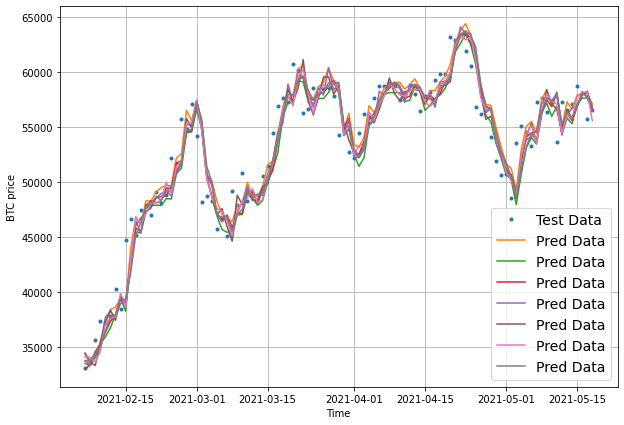

In [ ]:
#Let's plot our model 3 predictions
offset = 450
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels, start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_3_preds, start=offset, label="Pred Data", format="-")

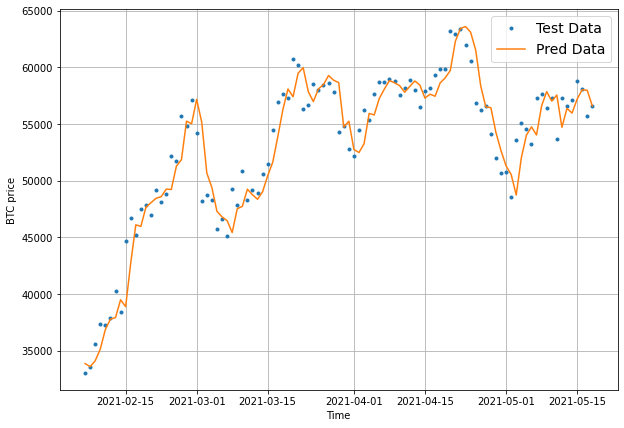

In [ ]:
#Let's plot our model 3 predictions
offset = 450
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels, start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=[tf.reduce_mean(model) for model in model_3_preds], 
                 start=offset, label="Pred Data", format="-")

## Which of our models is performing the best so far ?

In [ ]:
import pandas as pd
interm_results = pd.DataFrame({"naive": naive_results["mae"],
              "model_1_h1_w7": model_1_results["mae"],
              "model_2_h1_w30": model_2_results["mae"],
              "model_3_h7_w30": model_3_results["mae"]}, index=["mae"])

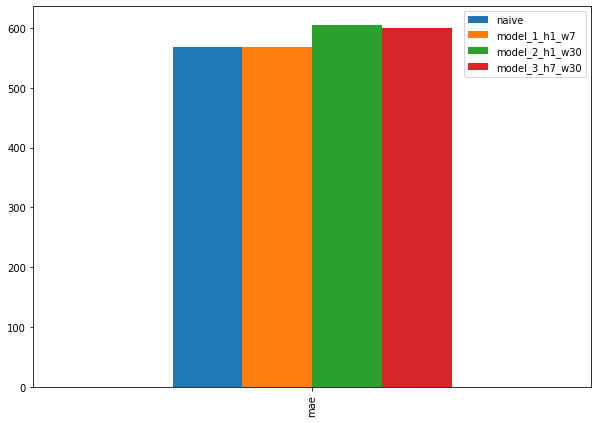

In [ ]:
interm_results.plot(figsize=(10, 7), kind="bar");

## Model 4: Conv1D

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# View the first 3
for i in range(3):
  print(f"Windows: {full_windows[i]} -> Label: {full_labels[i]}")

Windows: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: 123.033
Windows: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: 124.049
Windows: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: 125.96116


In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

To use the Conv1D layer, we need an input shape of (batch_size, timesteps, input_dim)...

In [ ]:
train_windows[0].shape

(7,)

In [ ]:
x = tf.constant(train_windows[0]) # turn our data into a tensor
x, x.shape

(<tf.Tensor: shape=(7,), dtype=float64, numpy=
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  ])>, TensorShape([7]))

In [ ]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dims

In [ ]:
# Test out our lambda layer
print(f"Original shape: {x.shape}")
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with expanded shape: \n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape: 
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [ ]:
# Create COnv1D Sequential
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    layers.GlobalMaxPool1D(),
    layers.Dense(HORIZON, activation="linear")
], name="model_4")

In [ ]:
# Compile the model
model_4.compile(loss="mae",
                optimizer="Adam",
                metrics=["mae", "mse"])

In [ ]:
model_4_history = model_4.fit(x=train_windows,
                              y=train_labels,
                              epochs=100,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name="model_4")])

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 2373.9048 - mae: 2373.9048 - mse: 15004059.0000  

18/18 [==============================] - 7s 55ms/step - loss: 2373.9048 - mae: 2373.9048 - mse: 15004059.0000 - val_loss: 5913.6226 - val_mae: 5913.6226 - val_mse: 63684764.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 698.1063 - mae: 698.1063 - mse: 1551420.7500

18/18 [==============================] - 1s 36ms/step - loss: 391.7078 - mae: 391.7078 - mse: 568387.6875 - val_loss: 1261.0900 - val_mae: 1261.0900 - val_mse: 5005920.5000
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 167.5612 - mae: 167.5612 - mse: 101047.9219

18/18 [==============================] - 1s 36ms/step - loss: 209.3953 - mae: 209.3953 - mse: 205822.6250 - val_loss: 1074.7179 - val_mae: 1074.7179 - val_mse: 3872922.7500
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 261.7132 - mae: 261.7132 - mse: 360407.6875

18/18 [==============================] - 1s 37ms/step - loss: 194.7531 - mae: 194.7531 - mse: 194745.6562 - val_loss: 1041.6313 - val_mae: 1041.6313 - val_mse: 3631216.0000
Epoch 5/100
17/18 [===========================>..] - ETA: 0s - loss: 187.0782 - mae: 187.0782 - mse: 181216.9844

18/18 [==============================] - 1s 53ms/step - loss: 185.0958 - mae: 185.0958 - mse: 178358.8281 - val_loss: 1031.7551 - val_mae: 1031.7551 - val_mse: 3499693.7500
Epoch 6/100
16/18 [=========================>....] - ETA: 0s - loss: 183.2354 - mae: 183.2354 - mse: 170474.3594

18/18 [==============================] - 1s 40ms/step - loss: 184.2087 - mae: 184.2087 - mse: 178613.7500 - val_loss: 1029.3267 - val_mae: 1029.3267 - val_mse: 3566220.7500
Epoch 7/100
17/18 [===========================>..] - ETA: 0s - loss: 183.0803 - mae: 183.0803 - mse: 178381.2344

18/18 [==============================] - 1s 38ms/step - loss: 182.3945 - mae: 182.3945 - mse: 176459.0469 - val_loss: 1001.5028 - val_mae: 1001.5028 - val_mse: 3352245.7500
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 161.4510 - mae: 161.4510 - mse: 102018.8359

18/18 [==============================] - 1s 36ms/step - loss: 177.2024 - mae: 177.2024 - mse: 167724.5312 - val_loss: 1000.5951 - val_mae: 1000.5951 - val_mse: 3254224.0000
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 174.5581 - mae: 174.5581 - mse: 163578.0000 - val_loss: 1003.6070 - val_mae: 1003.6070 - val_mse: 3207737.0000
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 191.8007 - mae: 191.8007 - mse: 250058.3125

18/18 [==============================] - 1s 37ms/step - loss: 172.2355 - mae: 172.2355 - mse: 159794.6406 - val_loss: 967.9227 - val_mae: 967.9227 - val_mse: 3066066.7500
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 192.0177 - mae: 192.0177 - mse: 153312.4531

18/18 [==============================] - 1s 36ms/step - loss: 169.5968 - mae: 169.5968 - mse: 154843.5938 - val_loss: 943.2490 - val_mae: 943.2490 - val_mse: 2980778.7500
Epoch 12/100
18/18 [==============================] - 0s 4ms/step - loss: 170.5143 - mae: 170.5143 - mse: 153177.0625 - val_loss: 947.7239 - val_mae: 947.7239 - val_mse: 2902619.0000
Epoch 13/100
18/18 [==============================] - 0s 4ms/step - loss: 165.8917 - mae: 165.8917 - mse: 146163.2031 - val_loss: 996.2909 - val_mae: 996.2909 - val_mse: 2986750.5000
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 185.3251 - mae: 185.3251 - mse: 161791.5156

18/18 [==============================] - 1s 36ms/step - loss: 162.8355 - mae: 162.8355 - mse: 142151.6562 - val_loss: 916.5764 - val_mae: 916.5764 - val_mse: 2725911.5000
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 155.9097 - mae: 155.9097 - mse: 86304.6172

18/18 [==============================] - 1s 36ms/step - loss: 163.2397 - mae: 163.2397 - mse: 143965.1719 - val_loss: 899.6814 - val_mae: 899.6814 - val_mse: 2636600.5000
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 152.3143 - mae: 152.3143 - mse: 98654.7969

18/18 [==============================] - 1s 36ms/step - loss: 156.4074 - mae: 156.4074 - mse: 133536.3594 - val_loss: 878.8237 - val_mae: 878.8237 - val_mse: 2539975.7500
Epoch 17/100
18/18 [==============================] - 0s 4ms/step - loss: 153.3354 - mae: 153.3354 - mse: 129838.5469 - val_loss: 917.7924 - val_mae: 917.7924 - val_mse: 2577657.5000
Epoch 18/100
18/18 [==============================] - 0s 4ms/step - loss: 151.7694 - mae: 151.7694 - mse: 127230.2578 - val_loss: 890.9282 - val_mae: 890.9282 - val_mse: 2462522.7500
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 86.2484 - mae: 86.2484 - mse: 36712.4961

18/18 [==============================] - 1s 35ms/step - loss: 148.3685 - mae: 148.3685 - mse: 121568.0156 - val_loss: 843.8820 - val_mae: 843.8820 - val_mse: 2306980.7500
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 155.5013 - mae: 155.5013 - mse: 140901.9219

18/18 [==============================] - 1s 36ms/step - loss: 146.1417 - mae: 146.1417 - mse: 119355.2500 - val_loss: 815.4083 - val_mae: 815.4083 - val_mse: 2258943.2500
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 203.5718 - mae: 203.5718 - mse: 186649.1406

18/18 [==============================] - 1s 36ms/step - loss: 144.6934 - mae: 144.6934 - mse: 116935.7109 - val_loss: 796.6483 - val_mae: 796.6483 - val_mse: 2115481.0000
Epoch 22/100
18/18 [==============================] - 0s 4ms/step - loss: 141.3039 - mae: 141.3039 - mse: 111072.7344 - val_loss: 798.3596 - val_mae: 798.3596 - val_mse: 2071061.6250
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 157.8294 - mae: 157.8294 - mse: 115868.5078

18/18 [==============================] - 1s 51ms/step - loss: 138.5618 - mae: 138.5618 - mse: 107429.8672 - val_loss: 793.4435 - val_mae: 793.4435 - val_mse: 2021242.5000
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 153.0976 - mae: 153.0976 - mse: 93487.3438

18/18 [==============================] - 1s 35ms/step - loss: 138.5321 - mae: 138.5321 - mse: 104809.7578 - val_loss: 772.8486 - val_mae: 772.8486 - val_mse: 1940114.3750
Epoch 25/100
18/18 [==============================] - ETA: 0s - loss: 135.3021 - mae: 135.3021 - mse: 102842.1094

18/18 [==============================] - 1s 36ms/step - loss: 135.3021 - mae: 135.3021 - mse: 102842.1094 - val_loss: 748.7429 - val_mae: 748.7429 - val_mse: 1854794.1250
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 136.4187 - mae: 136.4187 - mse: 74299.6172

18/18 [==============================] - 1s 36ms/step - loss: 132.5627 - mae: 132.5627 - mse: 98727.2422 - val_loss: 732.8300 - val_mae: 732.8300 - val_mse: 1824148.8750
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 192.5207 - mae: 192.5207 - mse: 181319.8125

18/18 [==============================] - 1s 36ms/step - loss: 132.0758 - mae: 132.0758 - mse: 98605.6016 - val_loss: 719.5884 - val_mae: 719.5884 - val_mse: 1754529.5000
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 129.8658 - mae: 129.8658 - mse: 90050.6094

18/18 [==============================] - 1s 37ms/step - loss: 128.6346 - mae: 128.6346 - mse: 93960.6797 - val_loss: 708.2429 - val_mae: 708.2429 - val_mse: 1691763.3750
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 125.2105 - mae: 125.2105 - mse: 78488.7812

18/18 [==============================] - 1s 36ms/step - loss: 127.8978 - mae: 127.8978 - mse: 92443.0469 - val_loss: 697.6255 - val_mae: 697.6255 - val_mse: 1638975.8750
Epoch 30/100
18/18 [==============================] - 0s 5ms/step - loss: 127.0851 - mae: 127.0851 - mse: 90213.5625 - val_loss: 744.8641 - val_mae: 744.8641 - val_mse: 1727227.3750
Epoch 31/100
18/18 [==============================] - 0s 5ms/step - loss: 132.0231 - mae: 132.0231 - mse: 93242.0625 - val_loss: 822.4292 - val_mae: 822.4292 - val_mse: 1944349.0000
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 133.7098 - mae: 133.7098 - mse: 87391.8203

18/18 [==============================] - 1s 37ms/step - loss: 133.9084 - mae: 133.9084 - mse: 92189.2500 - val_loss: 682.4522 - val_mae: 682.4522 - val_mse: 1548952.3750
Epoch 33/100
18/18 [==============================] - 0s 4ms/step - loss: 130.7890 - mae: 130.7890 - mse: 86711.3203 - val_loss: 684.8889 - val_mae: 684.8889 - val_mse: 1603402.8750
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 131.6121 - mae: 131.6121 - mse: 129456.1719

18/18 [==============================] - 1s 36ms/step - loss: 122.3547 - mae: 122.3547 - mse: 85903.9688 - val_loss: 662.3096 - val_mae: 662.3096 - val_mse: 1508565.8750
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 114.3333 - mae: 114.3333 - mse: 66670.0703

18/18 [==============================] - 1s 37ms/step - loss: 121.0187 - mae: 121.0187 - mse: 85368.3906 - val_loss: 659.4155 - val_mae: 659.4155 - val_mse: 1466844.8750
Epoch 36/100
18/18 [==============================] - 0s 4ms/step - loss: 122.4132 - mae: 122.4132 - mse: 84388.2188 - val_loss: 714.9786 - val_mae: 714.9786 - val_mse: 1591231.1250
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 154.2546 - mae: 154.2546 - mse: 114660.9375

18/18 [==============================] - 1s 51ms/step - loss: 120.9136 - mae: 120.9136 - mse: 82403.9141 - val_loss: 642.6025 - val_mae: 642.6025 - val_mse: 1423974.0000
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 113.5170 - mae: 113.5170 - mse: 74023.7578

18/18 [==============================] - 1s 36ms/step - loss: 118.4120 - mae: 118.4120 - mse: 82466.4844 - val_loss: 638.4052 - val_mae: 638.4052 - val_mse: 1416532.3750
Epoch 39/100
18/18 [==============================] - 0s 4ms/step - loss: 117.6049 - mae: 117.6049 - mse: 80715.3281 - val_loss: 648.5795 - val_mae: 648.5795 - val_mse: 1457676.7500
Epoch 40/100
18/18 [==============================] - ETA: 0s - loss: 116.0143 - mae: 116.0143 - mse: 80110.9531

18/18 [==============================] - 1s 37ms/step - loss: 116.0143 - mae: 116.0143 - mse: 80110.9531 - val_loss: 631.4584 - val_mae: 631.4584 - val_mse: 1371030.7500
Epoch 41/100
 1/18 [>.............................] - ETA: 0s - loss: 107.2781 - mae: 107.2781 - mse: 54172.4062

18/18 [==============================] - 1s 36ms/step - loss: 116.9355 - mae: 116.9355 - mse: 80573.6016 - val_loss: 623.6300 - val_mae: 623.6300 - val_mse: 1362898.1250
Epoch 42/100
 1/18 [>.............................] - ETA: 0s - loss: 110.7451 - mae: 110.7451 - mse: 65264.1484

18/18 [==============================] - 1s 35ms/step - loss: 119.0874 - mae: 119.0874 - mse: 82740.0078 - val_loss: 619.0330 - val_mae: 619.0330 - val_mse: 1340268.7500
Epoch 43/100
18/18 [==============================] - 0s 4ms/step - loss: 114.8294 - mae: 114.8294 - mse: 77196.8594 - val_loss: 627.2701 - val_mae: 627.2701 - val_mse: 1375892.5000
Epoch 44/100
18/18 [==============================] - 0s 4ms/step - loss: 116.1608 - mae: 116.1608 - mse: 78035.2734 - val_loss: 634.6339 - val_mae: 634.6339 - val_mse: 1395856.2500
Epoch 45/100
 1/18 [>.............................] - ETA: 0s - loss: 84.2513 - mae: 84.2513 - mse: 40183.4766

18/18 [==============================] - 1s 36ms/step - loss: 116.9051 - mae: 116.9051 - mse: 80552.1797 - val_loss: 611.1183 - val_mae: 611.1183 - val_mse: 1312373.3750
Epoch 46/100
18/18 [==============================] - 0s 4ms/step - loss: 113.7334 - mae: 113.7334 - mse: 76985.0469 - val_loss: 626.7640 - val_mae: 626.7640 - val_mse: 1334637.7500
Epoch 47/100
18/18 [==============================] - 0s 4ms/step - loss: 120.4477 - mae: 120.4477 - mse: 82769.0469 - val_loss: 707.7922 - val_mae: 707.7922 - val_mse: 1531583.0000
Epoch 48/100
18/18 [==============================] - 0s 4ms/step - loss: 117.2898 - mae: 117.2898 - mse: 78158.2109 - val_loss: 679.0837 - val_mae: 679.0837 - val_mse: 1456165.5000
Epoch 49/100
 1/18 [>.............................] - ETA: 0s - loss: 175.3963 - mae: 175.3963 - mse: 123683.1484

18/18 [==============================] - 1s 36ms/step - loss: 117.0481 - mae: 117.0481 - mse: 77595.7656 - val_loss: 600.6093 - val_mae: 600.6093 - val_mse: 1282213.7500
Epoch 50/100
18/18 [==============================] - 0s 4ms/step - loss: 112.4487 - mae: 112.4487 - mse: 76310.9375 - val_loss: 605.8607 - val_mae: 605.8607 - val_mse: 1300263.2500
Epoch 51/100
 1/18 [>.............................] - ETA: 0s - loss: 92.1663 - mae: 92.1663 - mse: 50807.5273

18/18 [==============================] - 1s 36ms/step - loss: 112.9928 - mae: 112.9928 - mse: 74701.0781 - val_loss: 597.2398 - val_mae: 597.2398 - val_mse: 1269869.3750
Epoch 52/100
18/18 [==============================] - 0s 4ms/step - loss: 113.4319 - mae: 113.4319 - mse: 77338.2422 - val_loss: 626.6485 - val_mae: 626.6485 - val_mse: 1354056.7500
Epoch 53/100
18/18 [==============================] - 0s 4ms/step - loss: 115.3752 - mae: 115.3752 - mse: 77508.8281 - val_loss: 618.8570 - val_mae: 618.8570 - val_mse: 1302975.1250
Epoch 54/100
18/18 [==============================] - 0s 4ms/step - loss: 116.6799 - mae: 116.6799 - mse: 78130.8594 - val_loss: 685.5676 - val_mae: 685.5676 - val_mse: 1461592.0000
Epoch 55/100
 1/18 [>.............................] - ETA: 0s - loss: 142.6679 - mae: 142.6679 - mse: 107452.6172

18/18 [==============================] - 1s 36ms/step - loss: 114.3888 - mae: 114.3888 - mse: 76257.4062 - val_loss: 592.7709 - val_mae: 592.7709 - val_mse: 1258963.7500
Epoch 56/100
18/18 [==============================] - 0s 4ms/step - loss: 112.0599 - mae: 112.0599 - mse: 75455.4219 - val_loss: 772.0572 - val_mae: 772.0572 - val_mse: 1786803.1250
Epoch 57/100
18/18 [==============================] - 0s 4ms/step - loss: 131.3105 - mae: 131.3105 - mse: 89229.3672 - val_loss: 634.1644 - val_mae: 634.1644 - val_mse: 1361403.3750
Epoch 58/100
18/18 [==============================] - 0s 4ms/step - loss: 119.9932 - mae: 119.9932 - mse: 80576.3125 - val_loss: 622.6703 - val_mae: 622.6703 - val_mse: 1332918.3750
Epoch 59/100
 1/18 [>.............................] - ETA: 0s - loss: 78.5053 - mae: 78.5053 - mse: 36707.6445

18/18 [==============================] - 1s 35ms/step - loss: 110.4792 - mae: 110.4792 - mse: 73729.8203 - val_loss: 589.8719 - val_mae: 589.8719 - val_mse: 1249422.0000
Epoch 60/100
18/18 [==============================] - 0s 4ms/step - loss: 110.6209 - mae: 110.6209 - mse: 74030.6172 - val_loss: 601.0742 - val_mae: 601.0742 - val_mse: 1258409.5000
Epoch 61/100
18/18 [==============================] - 0s 4ms/step - loss: 110.3178 - mae: 110.3178 - mse: 74530.3047 - val_loss: 597.4731 - val_mae: 597.4731 - val_mse: 1250305.1250
Epoch 62/100
 1/18 [>.............................] - ETA: 0s - loss: 77.4950 - mae: 77.4950 - mse: 42484.2031

18/18 [==============================] - 1s 37ms/step - loss: 110.2184 - mae: 110.2184 - mse: 72368.4062 - val_loss: 586.1464 - val_mae: 586.1464 - val_mse: 1238966.7500
Epoch 63/100
18/18 [==============================] - 0s 4ms/step - loss: 110.7868 - mae: 110.7868 - mse: 74156.6094 - val_loss: 586.4508 - val_mae: 586.4508 - val_mse: 1229779.6250
Epoch 64/100
18/18 [==============================] - 0s 4ms/step - loss: 110.1068 - mae: 110.1068 - mse: 73172.8125 - val_loss: 637.1649 - val_mae: 637.1649 - val_mse: 1329649.5000
Epoch 65/100
 1/18 [>.............................] - ETA: 0s - loss: 136.1950 - mae: 136.1950 - mse: 165265.1250

18/18 [==============================] - 1s 50ms/step - loss: 112.3310 - mae: 112.3310 - mse: 74861.1484 - val_loss: 582.4491 - val_mae: 582.4491 - val_mse: 1226797.3750
Epoch 66/100
18/18 [==============================] - 0s 4ms/step - loss: 112.2738 - mae: 112.2738 - mse: 73164.1875 - val_loss: 594.2973 - val_mae: 594.2973 - val_mse: 1255032.5000
Epoch 67/100
18/18 [==============================] - 0s 4ms/step - loss: 108.6237 - mae: 108.6237 - mse: 71365.4688 - val_loss: 606.3218 - val_mae: 606.3218 - val_mse: 1280293.6250
Epoch 68/100
18/18 [==============================] - 0s 4ms/step - loss: 114.9453 - mae: 114.9453 - mse: 72646.2422 - val_loss: 679.5665 - val_mae: 679.5665 - val_mse: 1467420.3750
Epoch 69/100
18/18 [==============================] - 0s 4ms/step - loss: 123.2751 - mae: 123.2751 - mse: 81540.6094 - val_loss: 693.2647 - val_mae: 693.2647 - val_mse: 1511975.3750
Epoch 70/100
18/18 [==============================] - 0s 4ms/step - loss: 122.0995 - mae: 122.0995 - m

18/18 [==============================] - 1s 36ms/step - loss: 108.1029 - mae: 108.1029 - mse: 71708.7500 - val_loss: 580.1818 - val_mae: 580.1818 - val_mse: 1219304.3750
Epoch 74/100
 1/18 [>.............................] - ETA: 0s - loss: 160.2217 - mae: 160.2217 - mse: 166496.5312

18/18 [==============================] - 1s 36ms/step - loss: 109.4704 - mae: 109.4704 - mse: 72832.1797 - val_loss: 577.4161 - val_mae: 577.4161 - val_mse: 1210856.1250
Epoch 75/100
18/18 [==============================] - 0s 4ms/step - loss: 108.5212 - mae: 108.5212 - mse: 71802.3750 - val_loss: 595.5109 - val_mae: 595.5109 - val_mse: 1233618.0000
Epoch 76/100
 1/18 [>.............................] - ETA: 0s - loss: 79.7593 - mae: 79.7593 - mse: 26311.7422

18/18 [==============================] - 1s 37ms/step - loss: 109.9715 - mae: 109.9715 - mse: 72589.1484 - val_loss: 574.1191 - val_mae: 574.1191 - val_mse: 1201057.3750
Epoch 77/100
 1/18 [>.............................] - ETA: 0s - loss: 84.8057 - mae: 84.8057 - mse: 65454.2500

18/18 [==============================] - 1s 36ms/step - loss: 110.2664 - mae: 110.2664 - mse: 71570.4844 - val_loss: 573.6545 - val_mae: 573.6545 - val_mse: 1198784.6250
Epoch 78/100
18/18 [==============================] - 0s 4ms/step - loss: 108.8185 - mae: 108.8185 - mse: 70854.2578 - val_loss: 587.3452 - val_mae: 587.3452 - val_mse: 1229025.8750
Epoch 79/100
18/18 [==============================] - 0s 4ms/step - loss: 109.3145 - mae: 109.3145 - mse: 73656.8906 - val_loss: 590.2826 - val_mae: 590.2826 - val_mse: 1233092.1250
Epoch 80/100
18/18 [==============================] - 0s 4ms/step - loss: 107.8420 - mae: 107.8420 - mse: 71687.8594 - val_loss: 579.6203 - val_mae: 579.6203 - val_mse: 1199437.1250
Epoch 81/100
18/18 [==============================] - 0s 4ms/step - loss: 109.5840 - mae: 109.5840 - mse: 71842.5000 - val_loss: 613.7510 - val_mae: 613.7510 - val_mse: 1281427.3750
Epoch 82/100
18/18 [==============================] - 0s 4ms/step - loss: 118.4723 - mae: 118.4723 - m

18/18 [==============================] - 1s 36ms/step - loss: 109.4286 - mae: 109.4286 - mse: 70790.5625 - val_loss: 571.2811 - val_mae: 571.2811 - val_mse: 1182194.8750
Epoch 88/100
18/18 [==============================] - 0s 4ms/step - loss: 108.8239 - mae: 108.8239 - mse: 71973.4688 - val_loss: 592.7592 - val_mae: 592.7592 - val_mse: 1231478.0000
Epoch 89/100
 1/18 [>.............................] - ETA: 0s - loss: 105.0470 - mae: 105.0470 - mse: 66041.1094

18/18 [==============================] - 1s 36ms/step - loss: 110.6100 - mae: 110.6100 - mse: 70855.3750 - val_loss: 569.7347 - val_mae: 569.7347 - val_mse: 1186286.1250
Epoch 90/100
18/18 [==============================] - 0s 4ms/step - loss: 107.6668 - mae: 107.6668 - mse: 68862.5938 - val_loss: 619.2398 - val_mae: 619.2398 - val_mse: 1272072.6250
Epoch 91/100
18/18 [==============================] - 0s 4ms/step - loss: 113.1797 - mae: 113.1797 - mse: 73929.3594 - val_loss: 616.8679 - val_mae: 616.8679 - val_mse: 1286784.5000
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 109.6112 - mae: 109.6112 - mse: 72983.1797 - val_loss: 572.0049 - val_mae: 572.0049 - val_mse: 1193198.2500
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 113.0264 - mae: 113.0264 - mse: 74077.5391 - val_loss: 620.9109 - val_mae: 620.9109 - val_mse: 1295719.6250
Epoch 94/100
18/18 [==============================] - 0s 4ms/step - loss: 109.4091 - mae: 109.4091 - m

In [ ]:
model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_4 = tf.keras.models.load_model("/content/model_experiement/model_4")

In [ ]:
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 569.7347 - mae: 569.7347 - mse: 1186286.1250


[569.7347412109375, 569.7347412109375, 1186286.125]

In [ ]:
# Make preds
model_4_preds = make_preds(model=model_4,
                           input_data=test_windows)
model_4_preds[:5]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8909.536, 8810.121, 9011.64 , 8805.829, 8761.862], dtype=float32)>

In [ ]:
model_4_results = evaluate_preds(y_true=test_labels,
                                 y_pred=model_4_preds)
model_4_results

{'mae': 569.73474,
 'mse': 1186286.2,
 'rmse': 1089.1676,
 'mape': 2.5618482,
 'mase': 1.0008662}

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

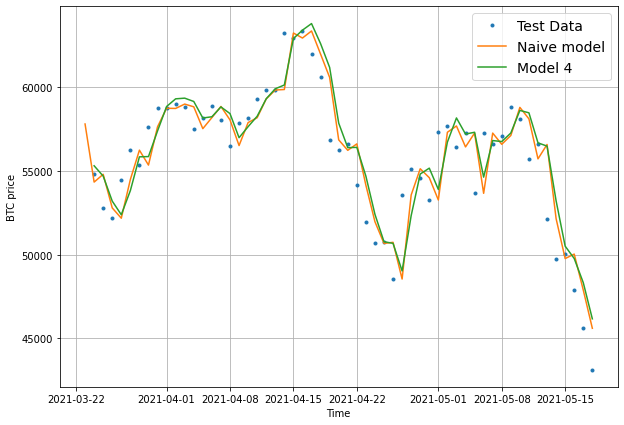

In [ ]:
#Let's plot our model 4 predictions
offset = 500
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels, start=offset, label="Test Data")
plot_time_series(timesteps=X_test[1:],
                 values=naive_forecast, start=offset, label="Naive model", format="-")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_4_preds, start=offset, label="Model 4", format="-")

## Model 5: LSTM

In [ ]:
tf.random.set_seed(42)

#Create the model
inputs = layers.Input(shape=(WINDOW_SIZE,))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs, output)

In [ ]:
# Compiel the model
model_5.compile(loss="mae",
                optimizer="Adam",
                metrics=["mae", "mse"])

In [ ]:
# Fit the model
model_5_history = model_5.fit(x=train_windows,
                              y=train_labels,
                              epochs=100,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name="model_5")])

Epoch 1/100
18/18 [==============================] - 4s 138ms/step - loss: 2430.3960 - mae: 2430.3960 - mse: 14903145.0000 - val_loss: 9471.2344 - val_mae: 9471.2344 - val_mse: 158901040.0000
Epoch 2/100
18/18 [==============================] - 2s 113ms/step - loss: 653.4048 - mae: 653.4048 - mse: 1568161.7500 - val_loss: 1945.4353 - val_mae: 1945.4353 - val_mse: 9762402.0000
Epoch 3/100
18/18 [==============================] - 2s 111ms/step - loss: 217.8997 - mae: 217.8997 - mse: 207374.3594 - val_loss: 993.6396 - val_mae: 993.6396 - val_mse: 3328137.5000
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 182.8415 - mae: 182.8415 - mse: 171049.2031 - val_loss: 1053.0714 - val_mae: 1053.0714 - val_mse: 3671617.2500
Epoch 5/100
18/18 [==============================] - 2s 110ms/step - loss: 180.3832 - mae: 180.3832 - mse: 163175.5781 - val_loss: 969.9511 - val_mae: 969.9511 - val_mse: 3151509.0000
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - lo

In [ ]:
model_5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda_2 (Lambda)           (None, 1, 7)              0         
                                                                 
 lstm (LSTM)                 (None, 128)               69632     
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 73,793
Trainable params: 73,793
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_5 = tf.keras.models.load_model("/content/model_experiement/model_5")

In [ ]:
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 582.6223 - mae: 582.6223 - mse: 1211086.5000


[582.6222534179688, 582.6222534179688, 1211086.5]

In [ ]:
# Make predictions
model_5_preds = make_preds(model_5, test_windows)

18/18 [==============================] - 1s 2ms/step


In [ ]:
model_5_results = evaluate_preds(y_true=test_labels,
                                 y_pred=model_5_preds)
model_5_results

{'mae': 582.6223,
 'mse': 1211086.5,
 'rmse': 1100.4938,
 'mape': 2.6325476,
 'mase': 1.023506}

## Make a multivariate time series dataset

In [ ]:
bitcoin_prices.head()

,price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009, out of our scope
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25

block_reward_2_datetime = np.datetime64("2012-11-08")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [ ]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days # date 3rd halving - 2013-10-01
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [ ]:
# Add a block reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None
bitcoin_prices_block.head()

,price,block_reward
Date,,
2013-10-01,123.65499,None
2013-10-02,125.45500,None
2013-10-03,108.58483,None
2013-10-04,118.67466,None
2013-10-05,121.33866,None


In [ ]:
bitcoin_prices_block.iloc[:block_reward_2_days,-1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days,-1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:,-1] = block_reward_4

In [ ]:
bitcoin_prices_block.head()

,price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [ ]:
bitcoin_prices_block.tail()

,price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


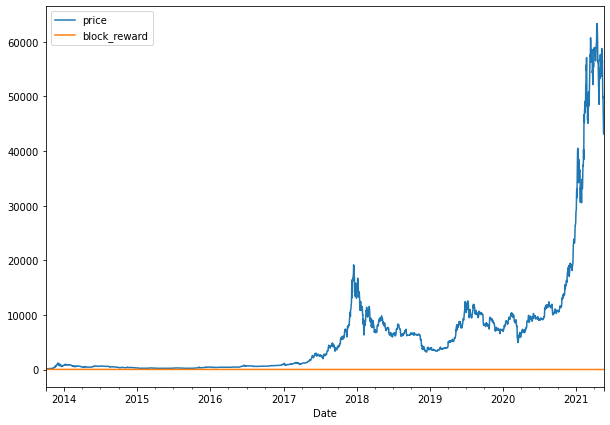

In [ ]:
bitcoin_prices_block.plot(figsize=(10,7));

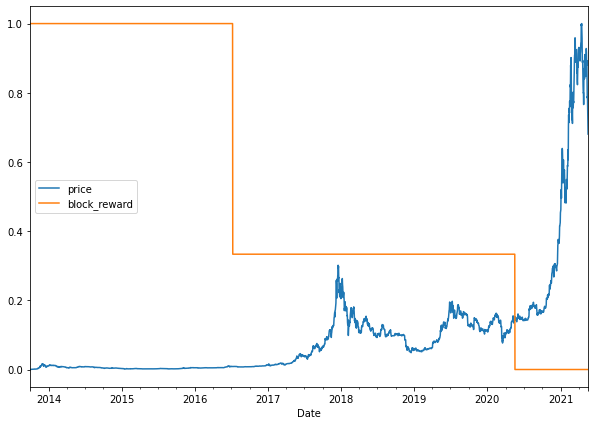

In [ ]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10,7)); 

## Making a windowed dataset with pandas

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
bitcoin_prices_windowed = bitcoin_prices_block.copy()

In [ ]:
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"price+{i+1}"] = bitcoin_prices_windowed["price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,price,block_reward,price+1,price+2,price+3,price+4,price+5,price+6,price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [ ]:
# Create X and y
X = bitcoin_prices_windowed.dropna().drop("price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["price"].astype(np.float32)

In [ ]:
X.head()

,block_reward,price+1,price+2,price+3,price+4,price+5,price+6,price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: price, dtype: float32

In [ ]:
# Creating training and testing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

## Model 6: Dense (multivariate time series)

In [ ]:
tf.random.set_seed(42)

# Create model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_6")

In [ ]:
# Compile
model_6.compile(loss="mae",
                optimizer="Adam",
                metrics=["mae", "mse"])

In [ ]:
# Fit
model_6_history = model_6.fit(x=X_train,
                              y=y_train,
                              epochs=100,
                              batch_size=128,
                              validation_data=(X_test, y_test),
                              callbacks=[create_model_checkpoint("model_6")])

Epoch 1/100
18/18 [==============================] - 1s 34ms/step - loss: 1234.6804 - mae: 1234.6804 - mse: 5282005.5000 - val_loss: 2061.9077 - val_mae: 2061.9077 - val_mse: 11377605.0000
Epoch 2/100
18/18 [==============================] - 0s 27ms/step - loss: 351.5053 - mae: 351.5053 - mse: 499358.0312 - val_loss: 1908.6733 - val_mae: 1908.6733 - val_mse: 8719443.0000
Epoch 3/100
18/18 [==============================] - 0s 28ms/step - loss: 235.4153 - mae: 235.4153 - mse: 276006.8125 - val_loss: 1329.0585 - val_mae: 1329.0585 - val_mse: 4991872.0000
Epoch 4/100
18/18 [==============================] - 0s 27ms/step - loss: 208.6112 - mae: 208.6112 - mse: 219502.7188 - val_loss: 1102.1342 - val_mae: 1102.1342 - val_mse: 3934655.5000
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 196.5770 - mae: 196.5770 - mse: 204309.3750 - val_loss: 1107.8474 - val_mae: 1107.8474 - val_mse: 3822059.0000
Epoch 6/100
18/18 [==============================] - 0s 29ms/step - loss

In [ ]:
model_6 = tf.keras.models.load_model("/content/model_experiement/model_6")

In [ ]:
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 567.8899 - mae: 567.8899 - mse: 1164816.5000


[567.889892578125, 567.889892578125, 1164816.5]

In [ ]:
# Make preds
model_6_preds = make_preds(model_6,
                           X_test)

18/18 [==============================] - 0s 1ms/step


In [ ]:
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 567.8899,
 'mse': 1164816.4,
 'rmse': 1079.2666,
 'mape': 2.5460758,
 'mase': 0.99762523}

In [ ]:
model_1_results

{'mae': 568.95105,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.9994894}

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

### Multivariated model with multi inputs

In [ ]:
X_train.head()

,block_reward,price+1,price+2,price+3,price+4,price+5,price+6,price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
X_train_price = X_train.drop("block_reward", axis=1)
X_train_block = X_train.block_reward
X_test_price = X_test.drop("block_reward", axis=1)
X_test_block = X_test.block_reward

In [ ]:
X_train_price_list = X_train_price.values.tolist()
X_train_block_list = X_train_block.tolist()
X_test_price_list = X_test_price.values.tolist()
X_test_block_list = X_test_block.tolist()
X_train_block_list[:5]

[25.0, 25.0, 25.0, 25.0, 25.0]

In [ ]:
model_6_1_train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_price_list, X_train_block_list), y_train))
model_6_1_val_dataset = tf.data.Dataset.from_tensor_slices(((X_test_price_list, X_test_block_list), y_test))

In [ ]:
model_6_1_train_dataset = model_6_1_train_dataset.batch(16).prefetch(tf.data.AUTOTUNE)
model_6_1_val_dataset = model_6_1_val_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_6_1_train_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [ ]:
# Create the model
price_input = layers.Input(shape=(7,), name="price_input")
price_output = layers.Dense(128, activation="relu")(price_input)
price_model = tf.keras.Model(price_input, price_output)

block_input = layers.Input(shape=(1), name="block_input")
block_output = layers.Dense(32, activation="relu")(block_input)
block_model = tf.keras.Model(block_input, block_output)

concat = layers.Concatenate()([price_model.output,
                               block_model.output])
x = layers.Dense(64, activation="relu")(concat)
output = layers.Dense(HORIZON)(x)
model_6_1 = tf.keras.Model(inputs=[price_model.inputs,
                                   block_model.inputs],
                           outputs=output)

In [ ]:
# Compile the model
model_6_1.compile(loss="mae",
                  optimizer="Adam",
                  metrics=["mae", "mse"])

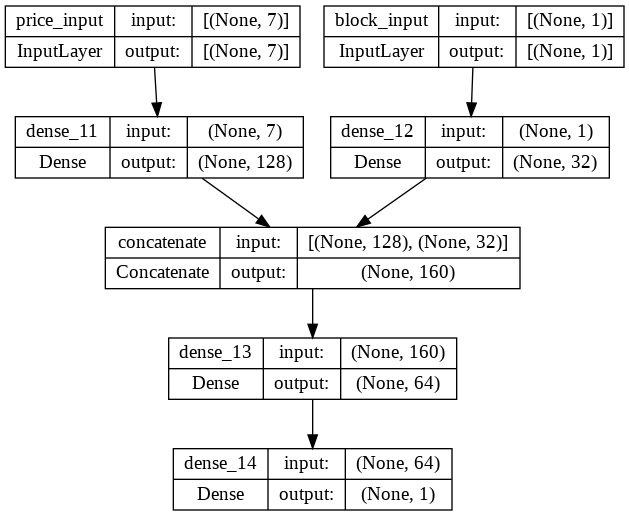

In [ ]:
tf.keras.utils.plot_model(model_6_1, show_shapes=True)

In [ ]:
model_6_1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 price_input (InputLayer)       [(None, 7)]          0           []                               
                                                                                                  
 block_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 dense_11 (Dense)               (None, 128)          1024        ['price_input[0][0]']            
                                                                                                  
 dense_12 (Dense)               (None, 32)           64          ['block_input[0][0]']            
                                                                                            

In [ ]:
# Fit the model
model_6_1_history = model_6_1.fit(model_6_1_train_dataset,
                                  epochs=100,
                                  batch_size=32,
                                  validation_data=model_6_1_val_dataset,
                                  callbacks=[create_model_checkpoint("model_6_1")])

Epoch 1/100
139/139 [==============================] - 2s 9ms/step - loss: 191.8194 - mae: 191.8194 - mse: 182096.2188 - val_loss: 741.4402 - val_mae: 741.4402 - val_mse: 1844914.1250
Epoch 2/100
139/139 [==============================] - 1s 9ms/step - loss: 168.1451 - mae: 168.1451 - mse: 149551.3906 - val_loss: 685.4011 - val_mae: 685.4011 - val_mse: 1609996.3750
Epoch 3/100
139/139 [==============================] - 0s 3ms/step - loss: 160.1754 - mae: 160.1754 - mse: 130706.9219 - val_loss: 715.0433 - val_mae: 715.0433 - val_mse: 1626458.6250
Epoch 4/100
139/139 [==============================] - 1s 9ms/step - loss: 153.4172 - mae: 153.4172 - mse: 119905.5469 - val_loss: 655.4420 - val_mae: 655.4420 - val_mse: 1497674.8750
Epoch 5/100
139/139 [==============================] - 1s 4ms/step - loss: 159.9012 - mae: 159.9012 - mse: 122712.9609 - val_loss: 843.1730 - val_mae: 843.1730 - val_mse: 1979884.8750
Epoch 6/100
139/139 [==============================] - 1s 5ms/step - loss: 136.5

In [ ]:
model_6_1 = tf.keras.models.load_model("/content/model_experiement/model_6_1")

In [ ]:
model_6_1.evaluate(model_6_1_val_dataset)

35/35 [==============================] - 0s 2ms/step - loss: 566.9822 - mae: 566.9822 - mse: 1157403.3750


[566.982177734375, 566.982177734375, 1157403.375]

In [ ]:
# make preds
model_6_1_preds = make_preds(model_6_1, model_6_1_val_dataset)

35/35 [==============================] - 0s 2ms/step


In [ ]:
model_6_1_results = evaluate_preds(y_true=y_test,
                                   y_pred=model_6_1_preds)
model_6_1_results

{'mae': 566.98224,
 'mse': 1157403.4,
 'rmse': 1075.8268,
 'mape': 2.5481372,
 'mase': 0.99603075}

## Model 7: N-BEATS algorithm

### Building and testing the N-BEATS block layer

In [ ]:
# Create N-BEAT block custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # **kwargs argument takes care of all the arguments for the parent class (input_shape, trainable...)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers 

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon]
    return backcast, forecast, theta

Let's test our NBeatsBlock class.
To do so, we'll make some dummy inputs and outputs.

In [ ]:
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
# Passdummy inputs to dummy NBeatsBlock layer
backcast, forecast, theta = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}\n")
print(f"Forecast: {tf.squeeze(forecast.numpy())}\n")
print(f"Theta: {theta}")

Backcast: [-0.49590105  0.22376382 -0.02924329 -0.13115686  0.09909858 -0.27410793
 -0.26703227]

Forecast: 0.04898370802402496

Theta: [[-0.49590105  0.22376382 -0.02924329 -0.13115686  0.09909858 -0.27410793
  -0.26703227  0.04898371]]


In [ ]:
theta[:,:7]

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[-0.49590105,  0.22376382, -0.02924329, -0.13115686,  0.09909858,
        -0.27410793, -0.26703227]], dtype=float32)>

In [ ]:
theta[:,-1]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.04898371], dtype=float32)>

### Prepraring data for the N-BEATS algorithm using `tf.data`

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create N-BEATS data inputs
bitcoin_prices.head()

,price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"price+{i+1}"] = bitcoin_prices_nbeats["price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

,price,price+1,price+2,price+3,price+4,price+5,price+6,price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
# Make features and labels 
X = bitcoin_prices_nbeats.dropna().drop("price", axis=1)
y = bitcoin_prices_nbeats.dropna().price

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train),len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
# Time to make our dataset performant using tf.data API
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
train_dataset = train_dataset.batch(1024).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(1024).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

In [ ]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

### Getting ready for residual connections

In [ ]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}\n")
print(f"Subtracted: {subtracted.numpy()}\n")
print(f"Added: {added.numpy()}")


Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]

Subtracted: [10 10 10 10 10 10 10 10 10 10]

Added: [10 12 14 16 18 20 22 24 26 28]


In [ ]:
tensor_1, tensor_2

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>)

### Building, compiling and fitting the N-BEATS algorithm

In [ ]:
%%time

tf.random.set_seed(42)

# 1. Setup and instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create an input layer
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast
residuals, forecast, _ = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # 1st stcak is already created in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast, _ = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass in the residuals

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBeats")

CPU times: user 1.23 s, sys: 5.56 ms, total: 1.24 s
Wall time: 1.23 s


In [ ]:
# 8. Compile the model
model_7.compile(loss="mae",
                optimizer="Adam",
                metrics=["mae", "mse"])

In [ ]:
%%time

# 9. Fit the model
model_7.fit(train_dataset,
           epochs=N_EPOCHS,
           validation_data=test_dataset,
           verbose=0,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                      patience=200,
                                                      restore_best_weights=True),
                     tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                          patience=100,
                                                          verbose=1)])


Epoch 792: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1174: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1274: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 3min 41s, sys: 9.5 s, total: 3min 50s
Wall time: 3min 52s


In [ ]:
# Evaluate the model
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 15ms/step - loss: 571.2192 - mae: 571.2192 - mse: 1163593.3750


[571.2191772460938, 571.2191772460938, 1163593.375]

In [ ]:
# Make predictions
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8840.545, 8773.751, 9039.337, 8772.867, 8748.794, 8745.92 ,
       8669.898, 8496.305, 8477.261, 8517.154], dtype=float32)>

In [ ]:
# Results
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 571.2192,
 'mse': 1163593.4,
 'rmse': 1078.6998,
 'mape': 2.5785196,
 'mase': 1.0034739}

In [ ]:
model_1_results

{'mae': 568.95105,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.9994894}

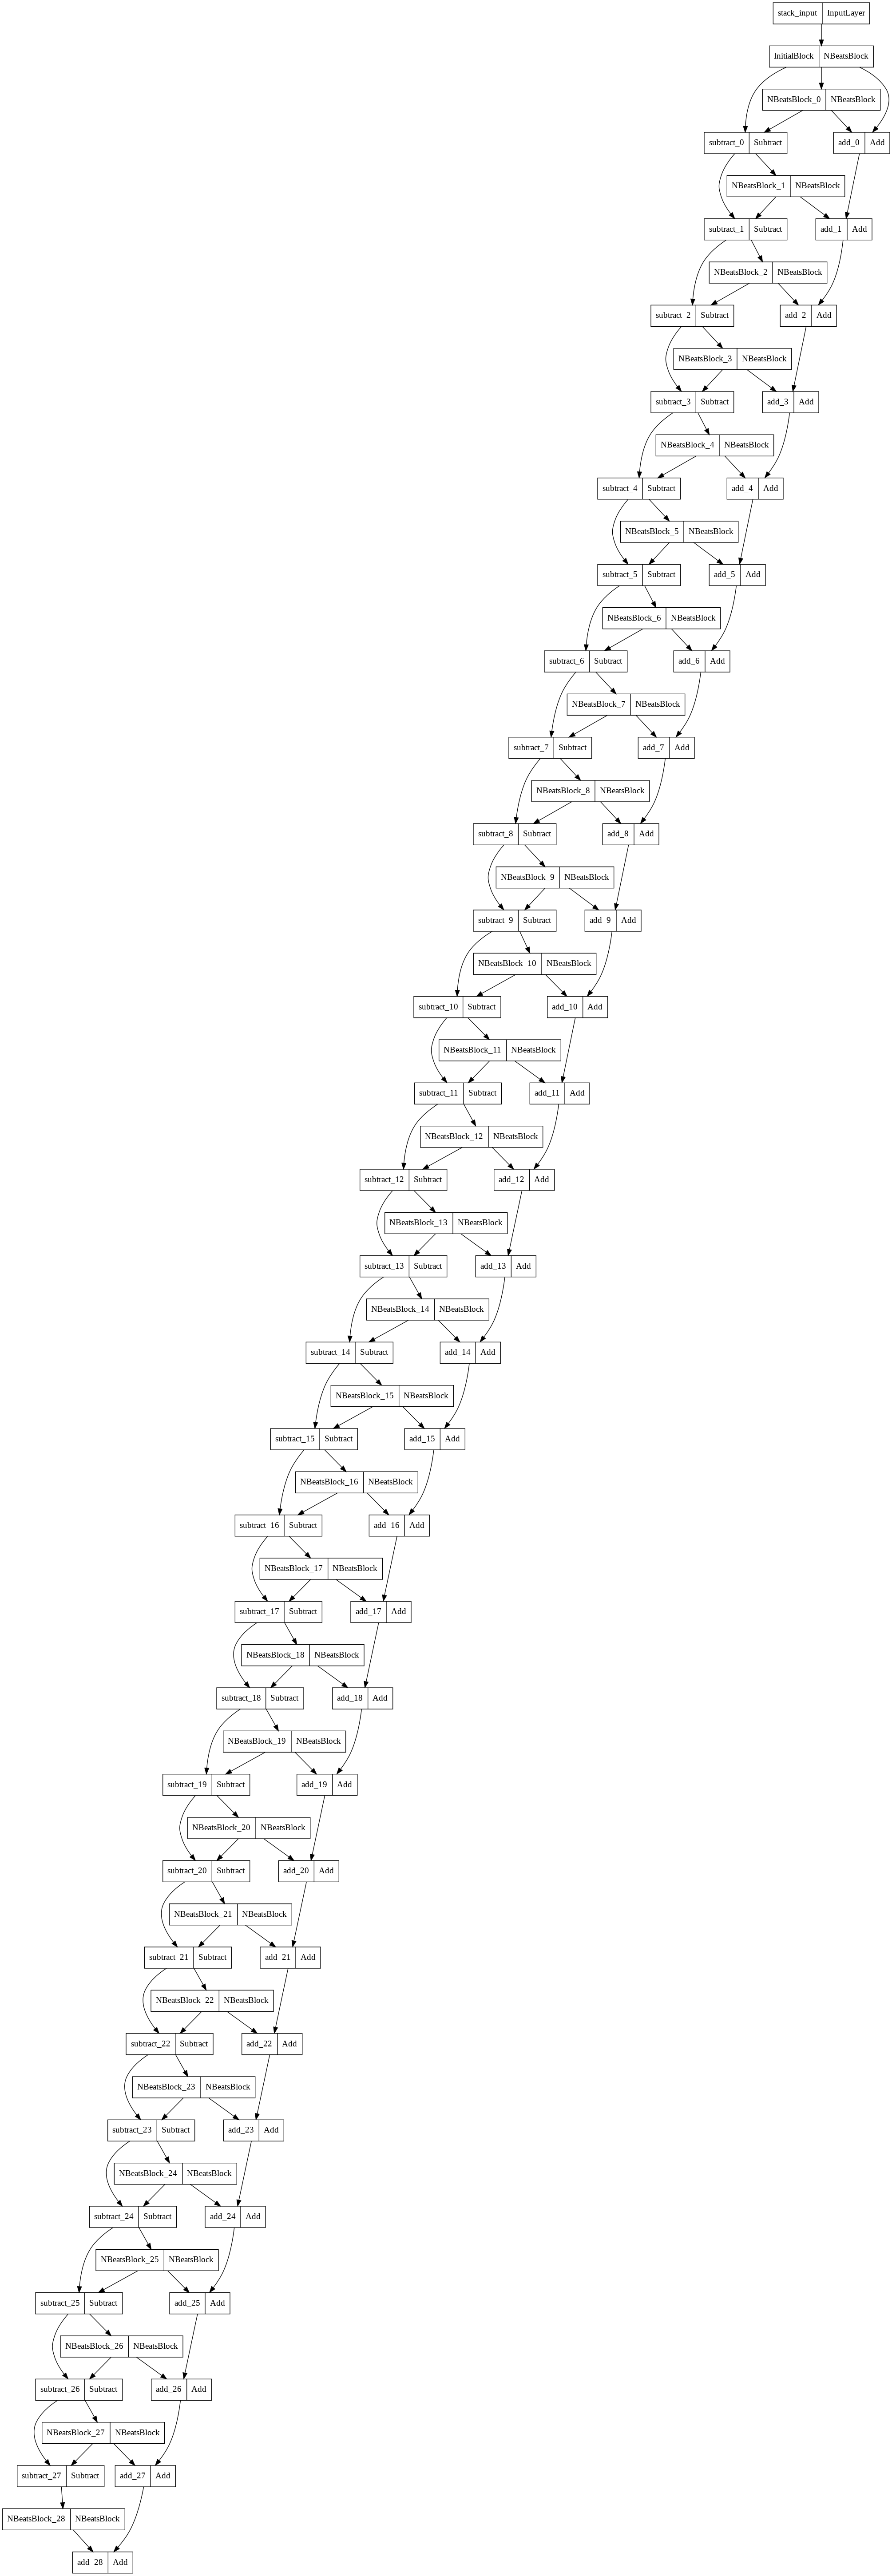

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8: Creating an ensemble (stacking different models together)

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns alist of num_iter models each trained on MAE, MSE and MAPE loss.
  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(loss_fns).
  """
  # Make a empty list for trined ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simplpe model (similar to model_1)
      model = tf.keras.Sequential([
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          #layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(HORIZON)
      ])

      # Compile simple model
      model.compile(loss=loss_function,
                    optimizer="Adam",
                    metrics=["mae", "mse"])
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, verbose=0, restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [ ]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 873: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 973: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 783: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 883: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 393: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 493: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 755: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 855: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by redu

In [ ]:
ensemble_models

### Making predictions with our ensemble model

In [ ]:
# Create a function for ensemble models
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_models, data=test_dataset)

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step
CPU times: user 496 ms, sys: 40.1 ms, total: 536 ms
Wall time: 496 ms


In [ ]:
ensemble_preds.shape

TensorShape([15, 556])

In [ ]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8794.717, 8784.636, 9056.107, 8720.555, 8745.707, 8728.847,
       8648.988, 8502.337, 8449.656, 8523.082], dtype=float32)>

In [ ]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:10]

array([8795.48 , 8790.487, 9063.992, 8723.745, 8748.512, 8738.117,
       8651.898, 8499.21 , 8451.257, 8528.597], dtype=float32)

In [ ]:
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_preds)
ensemble_results

{'mae': 572.3556,
 'mse': 1164815.4,
 'rmse': 1079.2429,
 'mape': 2.598001,
 'mase': 1.0054702}

In [ ]:
ensemble_results_mean = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_mean)
ensemble_results_mean

{'mae': 565.1142,
 'mse': 1143719.0,
 'rmse': 1069.448,
 'mape': 2.5526125,
 'mase': 0.9927491}

In [ ]:
ensemble_results_med = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_median)
ensemble_results_med

{'mae': 565.2626,
 'mse': 1148409.4,
 'rmse': 1071.6387,
 'mape': 2.5522935,
 'mase': 0.9930098}

### Plotting the predictions intervals (uncertainty estimates) of our ensembles

In [ ]:
def get_upper_lower(preds):
  # get std
  std = tf.math.reduce_std(preds, axis=0)

  # Multiply by 1.96 (for 95% confidence) (2*std = 95.5%)
  interval = std * 1.96

  # Get upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

In [ ]:
lower, upper = get_upper_lower(preds=ensemble_preds)
lower[:10], upper[:10]

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8749.636, 8752.981, 8998.696, 8666.41 , 8696.909, 8656.977,
        8597.81 , 8462.909, 8391.824, 8494.803], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8839.798, 8816.29 , 9113.519, 8774.699, 8794.505, 8800.717,
        8700.167, 8541.765, 8507.488, 8551.361], dtype=float32)>)

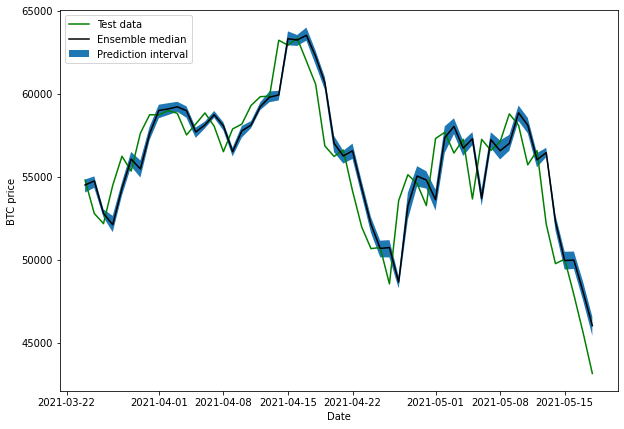

In [ ]:
# get the median values of our preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median and the interval preds
offset = 500
plt.figure(figsize=(10,7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble median")
plt.xlabel("Date")
plt.ylabel("BTC price")
plt.fill_between(X_test.index[offset:],
                 lower[offset:],
                 upper[offset:], label="Prediction interval")
plt.legend(loc="upper left");


## Model 9: Future prediction model

So far all of our models have predicted on the test datset.
Let's now build a model which is capable of predicting in to the future !

In [ ]:
bitcoin_prices_windowed.head()

,price,block_reward,price+1,price+2,price+3,price+4,price+5,price+6,price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Train model on entire data
X_all = bitcoin_prices_windowed.dropna().drop(["price", "block_reward"], axis=1).to_numpy()
y_all = bitcoin_prices_windowed.dropna().price.to_numpy()

In [ ]:
len(X_all), len(y_all)

(2780, 2780)

In [ ]:
dataset_all = tf.data.Dataset.from_tensor_slices((X_all, y_all))

In [ ]:
dataset_all = dataset_all.batch(1024).prefetch(tf.data.AUTOTUNE)

In [ ]:
dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
# Create the model
inputs = layers.Input(shape=(7,), dtype="float64")
x = layers.Dense(128, activation="relu", kernel_initializer="glorot_normal")(inputs)
outputs = layers.Dense(HORIZON, activation="linear")(x)
model_9 = tf.keras.Model(inputs, outputs)

In [ ]:
model_9.compile(loss=tf.keras.losses.MAE,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

In [ ]:
model_9.fit(dataset_all,
            epochs=1000,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss",
                                                       patience=200,
                                                       verbose=0,
                                                       restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",
                                                            patience=100,
                                                            verbose=1)])


Epoch 114: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.


### Make predictions into future

In [ ]:
# How many timesteps to predict ointo the future?
INTO_FUTURE = 14

In [ ]:
# 1.Create function to make predictions to the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after values ends.
  Returns future forecasts as a list of floats.
  """
  # 2.Create an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE :]

  # 3.Make INTO_FUTURE number of predictions, alter the data with each pred
  for _ in range(INTO_FUTURE):
    # Predcict on the last window then append it again, again...
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predictiong on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append to future forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE :]

  return future_forecast

In [ ]:
future_forecast = make_future_forecasts(values=y_all,
                                        model=model_9,
                                        into_future=INTO_FUTURE,
                                        window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 35ms/step
Predictiong on:
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 56355.16015625

1/1 [==============================] - 0s 13ms/step
Predictiong on:
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 56355.16015625] -> Prediction: 52255.57421875

1/1 [==============================] - 0s 13ms/step
Predictiong on:
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 56355.16015625 52255.57421875] -> Prediction: 50021.23046875

1/1 [==============================] - 0s 13ms/step
Predictiong on:
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 56355.16015625 52255.57421875 50021.23046875] -> Prediction: 50227.56640625

1/1 [==============================] - 0s 12ms/step
Predictiong on:
 [47885.62525472 45604.61575361 43144.47129086 56355.16015625
 52255.57421875 50021.23046875 50227.5

In [ ]:
future_forecast

[56355.16,
 52255.574,
 50021.23,
 50227.566,
 47050.223,
 44657.234,
 45723.18,
 56237.66,
 52374.867,
 50382.43,
 50042.797,
 46126.33,
 44429.09,
 47901.004]

### Plot future forecast

In [ ]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D")
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [ ]:
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [ ]:
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

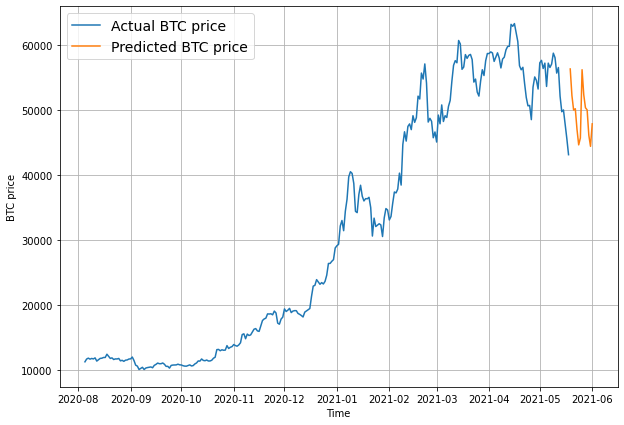

In [ ]:
# Plot future prices
plt.figure(figsize=(10,7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC price")

In [ ]:
# INsert last timestep/final price for no discountinuity
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 56355.16 , 52255.574, 50021.23 , 50227.566, 47050.223,
        44657.234, 45723.18 , 56237.66 , 52374.867, 50382.43 , 50042.797,
        46126.33 , 44429.09 , 47901.004], dtype=float32))

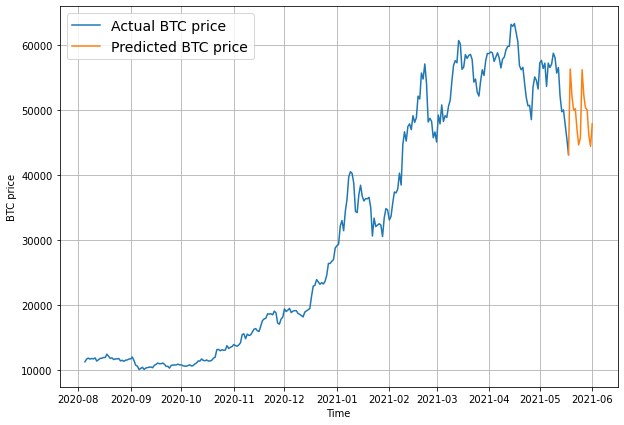

In [ ]:
# Plot future prices
plt.figure(figsize=(10,7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC price")

## Model 10: Introduction to turkey problem

In [ ]:
btc_price[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 43144.4712908603]

In [ ]:
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [ ]:
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [ ]:
btc_timesteps_turkey = np.array(bitcoin_prices.index)

In [ ]:
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

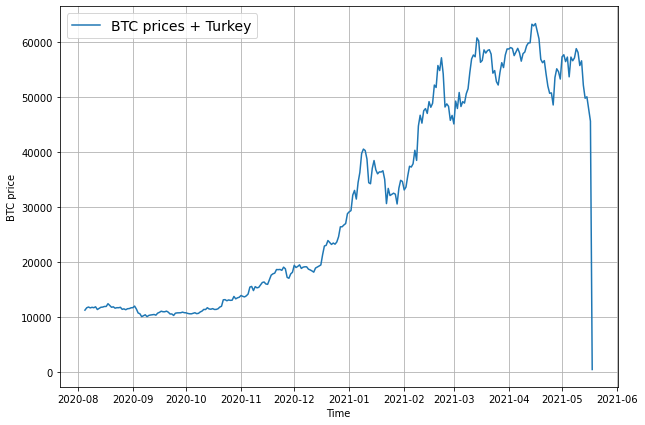

In [ ]:
plt.figure(figsize=(10,7))
plot_time_series(btc_timesteps_turkey, btc_price_turkey, start=2500, format="-", label="BTC prices + Turkey")

In [ ]:
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)

In [ ]:
turkey_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
turkey_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
turkey_train = turkey_train.batch(128).prefetch(tf.data.AUTOTUNE)
turkey_test = turkey_test.batch(128).prefetch(tf.data.AUTOTUNE)

In [ ]:
turkey_train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
# Create the model
inputs = layers.Input(shape=(7,), dtype="float64")
x = layers.Dense(128, activation="relu", kernel_initializer="he_normal")(inputs)
outputs = layers.Dense(1, activation="linear")(x)

model_10 = tf.keras.Model(inputs, outputs)

In [ ]:
model_10.compile(loss="mae",
                 optimizer="Adam",
                 metrics=["mae", "mse"])

In [ ]:
model_10.fit(turkey_train,
             validation_data=turkey_test,
             epochs=100,
             verbose=0,
             callbacks=[create_model_checkpoint(model_name="turkey_model")])

In [ ]:
model_10 = tf.keras.models.load_model("model_experiement/turkey_model")

In [ ]:
# Make prediction
model_10_preds = make_preds(model_10,
                            X_test)

18/18 [==============================] - 0s 1ms/step


In [ ]:
model_10_results = evaluate_preds(y_true=y_test,
                                  y_pred=model_10_preds)

In [ ]:
model_10_results

{'mae': 934.4637,
 'mse': 6055595.0,
 'rmse': 2460.8118,
 'mape': 23.458225,
 'mase': 1.4460856}

In [ ]:
model_1_results

{'mae': 568.95105,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.9994894}

## Compare models

In [ ]:
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_Conv1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_6_1_multi_perso": model_6_1_results,
                              "model_7_NBeats": model_7_results,
                              "model_8_ensemble": ensemble_results,
                              "model_10_turkey": model_10_results}).T
model_results

,mae,mse,rmse,mape,mase
naive_model,567.980225,1147547.000,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,568.951050,1171743.750,1082.471069,2.544898,0.999489
model_2_dense_w30_h1,605.874084,1273360.750,1128.432861,2.726445,1.059074
model_3_dense_w30_h7,600.749695,1237823.250,628.369934,2.837898,1.094201
model_4_Conv1D,569.734741,1186286.250,1089.167603,2.561848,1.000866
model_5_LSTM,582.622314,1211086.500,1100.493774,2.632548,1.023506
model_6_multivariate,567.889893,1164816.375,1079.266602,2.546076,0.997625
model_6_1_multi_perso,566.982239,1157403.375,1075.826782,2.548137,0.996031
model_7_NBeats,571.219177,1163593.375,1078.699829,2.578520,1.003474
model_8_ensemble,572.355591,1164815.375,1079.242920,2.598001,1.005470


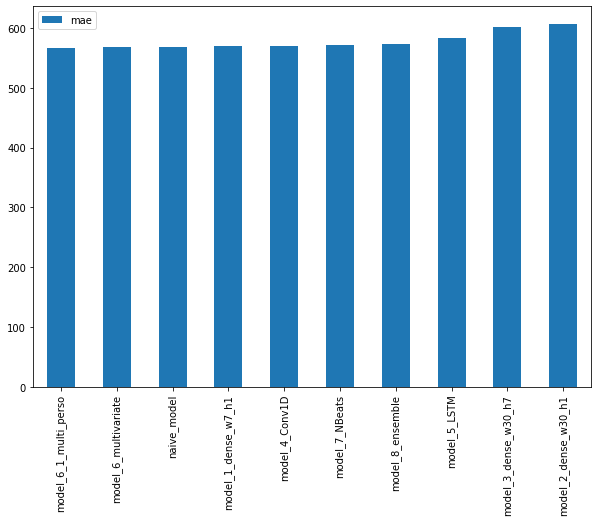

In [ ]:
# Sort by mae and plot
model_results.drop("model_10_turkey", axis=0)[["mae"]].sort_values(by="mae").plot(figsize=(10,7), kind="bar")